In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt

%aimport dataset
%aimport transforms

VideoData = dataset.VideoData
VideoTransforms = transforms.VideoTransforms

In [14]:
datestamp = '20220829'
views = ['pdaRelatedView', 'pdaView']
modes = ['2d', 'color', 'color_compare']
bs = 16  # batch size for training
num_workers = 5  # number of parallel data loading workers
res = 224 # pixel size along height and width
device = torch.device('cpu')
num_classes = 3

In [15]:
tf = VideoTransforms(224)
tfms = tf.get_transforms('plot')
tfms

Compose(
    ConvertImageDtype()
    UpsamplingBilinear2d(size=224, mode=bilinear)
    CenterCrop(size=(224, 224))
)

In [16]:
df_frame = pd.read_csv(f'/zfs/wficai/pda/model_data/{datestamp}_frame.csv')
df_video = pd.read_csv(f'/zfs/wficai/pda/model_data/{datestamp}_video.csv')
df_study = pd.read_csv(f'/zfs/wficai/pda/model_data/{datestamp}_study.csv')
df_patient_study = pd.read_csv(f'/zfs/wficai/pda/model_data/{datestamp}_patient_study.csv')
df_patient = pd.read_csv(f'/zfs/wficai/pda/model_data/{datestamp}_patient.csv')

In [17]:
df_patient.columns, df_patient_study.columns, df_study.columns, df_video.columns, df_frame.columns

(Index(['patient_id', 'num_studies'], dtype='object'),
 Index(['patient_id', 'patient_type', 'study', 'num_videos'], dtype='object'),
 Index(['patient_type', 'study', 'num_videos', 'num_frames'], dtype='object'),
 Index(['external_id', 'patient_type', 'num_frames', 'view', 'mode',
        'diagnosis', 'study', 'mp4_path'],
       dtype='object'),
 Index(['patient_type', 'external_id', 'png_path'], dtype='object'))

In [18]:
# create datasets
df = df_patient.merge(df_patient_study).merge(df_study, on=['patient_type', 'study']).merge(df_video, on=['patient_type', 'study']).merge(df_frame, on=['patient_type', 'external_id'])
df.head()

,patient_id,num_studies,patient_type,study,num_videos_x,num_videos_y,num_frames_x,external_id,num_frames_y,view,mode,diagnosis,mp4_path,png_path
0,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/zfs/wficai/pda/batch_1/PDA_Batch_1/Superior V...,/zfs/wficai/pda/model_data/20220829/pda_study2...
1,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/zfs/wficai/pda/batch_1/PDA_Batch_1/Superior V...,/zfs/wficai/pda/model_data/20220829/pda_study2...
2,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/zfs/wficai/pda/batch_1/PDA_Batch_1/Superior V...,/zfs/wficai/pda/model_data/20220829/pda_study2...
3,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/zfs/wficai/pda/batch_1/PDA_Batch_1/Superior V...,/zfs/wficai/pda/model_data/20220829/pda_study2...
4,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/zfs/wficai/pda/batch_1/PDA_Batch_1/Superior V...,/zfs/wficai/pda/model_data/20220829/pda_study2...


# Examine

In [19]:
d = VideoData(df, transforms = tfms, mode_filter = modes, view_filter = views)

In [20]:
d.video_data

,study,patient_id,patient_type,external_id,mode,trg_type,trg_view,trg_mode
2225,study22,01578f3a19fbf0f2,pda,study22_dicom58,2d,1,1,0
2296,study22,01578f3a19fbf0f2,pda,study22_dicom59,color_compare,1,1,2
2383,study22,01578f3a19fbf0f2,pda,study22_dicom63,color_compare,1,2,2
2480,study22,01578f3a19fbf0f2,pda,study22_dicom67,color_compare,1,2,2
2745,study22,01578f3a19fbf0f2,pda,study22_dicom69,2d,1,1,0
...,...,...,...,...,...,...,...,...
204109,study36,f8dd48f1f7946612,pda,study36_dicom50,2d,1,2,0
204139,study36,f8dd48f1f7946612,pda,study36_dicom52,color,1,2,1
205192,study36,f8dd48f1f7946612,pda,study36_dicom69,2d,1,1,0
205273,study36,f8dd48f1f7946612,pda,study36_dicom70,color,1,1,1


In [21]:
dl = DataLoader(d, batch_size=8, num_workers=0, collate_fn = d.collate, shuffle=True)

In [22]:
batch = next(iter(dl))

In [37]:
batch['video'].shape, transforms.RandomDownsampleTime(4)(batch['video']).shape

(torch.Size([650, 3, 224, 224]), torch.Size([162, 3, 224, 224]))

In [12]:
batch.keys()

dict_keys(['video', 'mask', 'trg_type', 'trg_view', 'trg_mode', 'study', 'patient'])

In [13]:
batch['video'].shape

torch.Size([788, 3, 224, 224])

In [14]:
batch['mask'], batch['mask'].shape

(tensor([[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False,  True],
         [False, False, False,  ..., False, False,  True],
         [False, False, False,  ..., False, False,  True]]),
 torch.Size([788, 8]))

In [15]:
batch['trg_type']

tensor([1, 0, 1, 0, 0, 1, 1, 0])

In [16]:
batch['trg_view']

tensor([2, 1, 2, 1, 1, 1, 1, 1])

In [17]:
batch['trg_mode']

tensor([2, 0, 2, 2, 1, 0, 0, 0])

In [18]:
batch['study']

['study18',
 'study56',
 'study7',
 'study49',
 'study48',
 'study39',
 'study10',
 'study19']

In [19]:
batch['patient']

['cf3c3d36b9374d58',
 '7c599c39faa69203',
 '0a3d6256c8e10c73',
 '9518057baa5f8ed1',
 '048d893a43658996',
 'b6409b05e145bb21',
 '6eaaa0b75d1a38c7',
 '6857cc93c05d8d97']

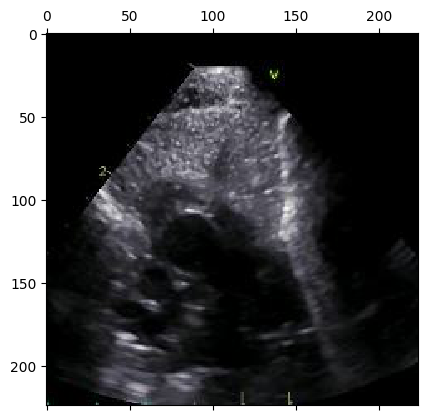

In [24]:
img = batch['video'][90].permute(1,2,0)
plt.matshow(img)

In [21]:
img.min()

tensor(0.)

In [22]:
img.max()

tensor(0.9059)